In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums
from tqdm import tqdm_notebook

from model import SimpleFlat, SimpleIndependent, SimpleJoint

sns.set_context('talk')

In [36]:
gamma = 0.80
n_rooms = 10
n_doors = 3
sucessor_function = np.zeros((n_rooms, n_doors), dtype=int)
true_transition_clusters = [0, 1, 2, 3, 4] * (n_rooms/5)
# true_transition_clusters = [0, 1] * (n_rooms/2)


# door "0" goes to the next room for for rooms 0-(n-1), 
#  and the for the last room, this door goes to itself
# door "1" always goes to room 1
# door "2" always goes to room 1


for d in range(n_rooms - 1):
    sucessor_function[d, 0] = d+1
sucessor_function[n_rooms-1, 0] = n_rooms-1

for d in range(n_rooms):
    sucessor_function[d, 1] = 0
    sucessor_function[d, 2] = 0

reward_function = np.zeros((n_rooms, n_doors))
reward_function[:, 1] = -1.0
reward_function[:, 2] = -1.0
reward_function[0:n_rooms-1, 0] = 0
reward_function[n_rooms-1, 0] = 1.0

r_set = set(np.ndarray.flatten(reward_function))

In [37]:
class simple_indepedent(object):
    def __init__(self, beta, alpha, n_doors=3):

        # initialize the rewards such that each cluster has a prior corresponding to  
        # 1e-5 of an event for each possible reward value for each door
        self.r_events = []
        self.beta = beta
        self.alpha = float(alpha)
        self.visited_rooms = set()
        self.cluster_probabilities = dict()
        
        self.n_doors = n_doors
        
    def pick_door(self, room):
        
        # if this is a new room, generate its prior over the clusters
        if room not in self.visited_rooms:
            self.visited_rooms.add(room) 
            
            N = len(self.visited_rooms) - 1 # total number of rooms visited
            
            # count the cluster assignments
            cluster_counts = np.zeros(N, dtype=int)
            for room0, pmf in self.cluster_probabilities.iteritems():
                cluster_counts[np.argmax(pmf)] += 1

                # while we're here, augment the size of the previously seen PMFs 
                # p(room) = cluster with to be the correct shape
                self.cluster_probabilities[room0] = np.concatenate([pmf, np.zeros(1)])

            # initialize the prior probability p(new room) = cluster with the CRP
            pmf = np.zeros(N + 1)
            for k, N_k in enumerate(cluster_counts):
                pmf[k] = N_k / (alpha + N)
            pmf[N] = alpha / (alpha + N)
            # this is the prior for the new room only!
            self.cluster_probabilities[room] = pmf 
            
            # initialize new q functions for the new (potential) cluster
            self.r_events += [{door: {r:1e-5 for r in r_set} for door in range(n_doors)}]


        # ~~~~~ choose the maximum a posteriori context assignment ~~~~~
        k_max = np.argmax(self.cluster_probabilities[room])
        
        # ~~~~~ have the model pick the goal ~~~~~
        q = np.zeros(self.n_doors)
        for door in range(n_doors):
            # get the E[V] of the door! 
            n = np.sum(self.r_events[k_max][door].values())
            for r0, n_r0 in self.r_events[k_max][door].iteritems():
                q[door] += r0 * n_r0 / n
            
        pmf = softmax_to_pdf(q, self.beta)
        return sample_cmf(pmf.cumsum())
                             
    def update(self, room, door, r):
        # note! the assumption is that the room will always be in the set of 
        # visited rooms, because that update happens when the agent selects an action
        
        prior = self.cluster_probabilities[room]
        posterior = np.zeros(np.shape(prior)) # initialize
        for k, pr_k in enumerate(prior):
            
            # Have to regenerate the probability of reward conditional on cluster k
            n = np.sum(self.r_events[k][door].values())
            n_r = self.r_events[k][door][r]
            pr_r = n_r / n
            
            # update the posterior
            posterior[k] = pr_r * pr_k
            
        posterior /= posterior.sum()  # normalize
        self.cluster_probabilities[door] = posterior
        
        k_max = np.argmax(self.cluster_probabilities)
        
        # update the statics on the MAP cluster only
        self.r_events[k_max][door][r] += 1.0
        

In [38]:
inverse_temp = 10.0
alpha = 1.0

n_sim = 500

def run_rooms(agent_class, params, desc, n_sim=1000):
    steps_to_goal = [None] * n_sim
    for ii in tqdm_notebook(range(n_sim), desc=desc, leave=False):

        current_room = 0
        t = 0

        agent = agent_class(*params)
        while True:
            door = agent.pick_door(current_room)
            r = reward_function[current_room, door]
            new_room = sucessor_function[current_room, door]

            agent.update(current_room, door, r)

            current_room = new_room
            t += 1
            if r == 1:
                break
        steps_to_goal[ii] = t 
    return steps_to_goal

flat_params = [inverse_temp, n_doors]
joint_params = [inverse_temp, alpha, true_transition_clusters, n_doors]
indep_params = [inverse_temp, alpha, n_doors]

steps_to_goal_flat = run_rooms(SimpleFlat, flat_params, 'Flat', n_sim)
steps_to_goal_joint = run_rooms(SimpleJoint, joint_params, 'Joint', n_sim)
steps_to_goal_indep = run_rooms(simple_indepedent, flat_params, 'Independent', n_sim)


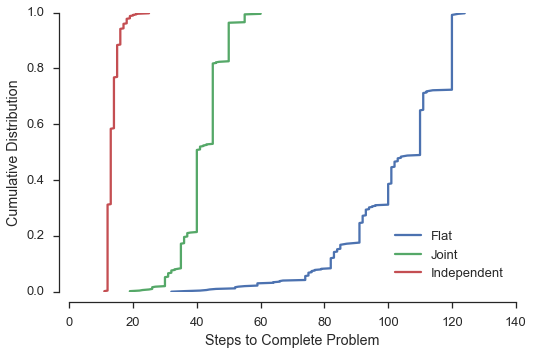

In [39]:
steps_to_goal_flat.sort()
steps_to_goal_joint.sort()
steps_to_goal_indep.sort()

y = np.arange(0, n_sim, dtype=float) / n_sim

with sns.axes_style('ticks'):
    plt.figure(figsize=(8, 5))
    plt.plot(steps_to_goal_flat, y, label='Flat')
    plt.plot(steps_to_goal_joint, y, label='Joint')
    plt.plot(steps_to_goal_indep, y, label='Independent')
    ax = plt.gca()
    ax.set_ylabel('Cumulative Distribution')
    ax.set_xlabel('Steps to Complete Problem')
    plt.legend(loc='lower right')
    sns.despine(offset=10)

    

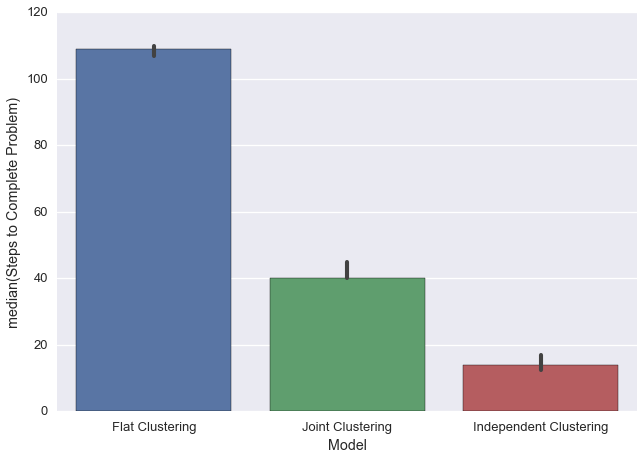

In [40]:
import pandas as pd
X = pd.DataFrame({
        'Steps to Complete Problem': steps_to_goal + \
        steps_to_goal_joint + \
        steps_to_goal_ind,
        'Model': 
        ['Flat Clustering'] * len(steps_to_goal) + \
        ['Joint Clustering'] * len(steps_to_goal_joint) + \
        ['Independent Clustering'] * len(steps_to_goal_ind)
    })
sns.barplot(data=X, x='Model', y='Steps to Complete Problem', estimator=np.median)